In [1]:
from scipy.io import loadmat
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatreader import read_mat
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import eeg_funcs
import os

Normal data creation with Basic 2D model

In [2]:
discriminator_b = keras.Sequential(
    [
        keras.Input(shape=(160, 8, 1)),
        layers.Conv2D(64, kernel_size=(4,4), strides=(2,2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv2D(128, kernel_size=(4,4), strides=(2,2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator_b.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 4, 64)         1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 80, 4, 64)         0         
                                                                 
 dropout (Dropout)           (None, 80, 4, 64)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 2, 128)        131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 2, 128)        0         
                                                                 
 dropout_1 (Dropout)         (None, 40, 2, 128)        0         
                                                                 
 flatten (Flatten)           (None, 10240)           

In [3]:
latent_dim_b = 160

generator_b = keras.Sequential(
    [
        keras.Input(shape=(latent_dim_b,)),
        layers.Dense(10*1*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((10, 1, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1, (4, 4), strides=(2, 1), padding='same', use_bias=False, activation='tanh'),
    ],
    name="generator",
)
generator_b.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2560)              409600    
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2560)              0         
                                                                 
 reshape (Reshape)           (None, 10, 1, 256)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 20, 2, 128)       524288    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 20, 2, 128)       51

In [4]:
class GANB(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GANB, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GANB, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Check the right checkpoint filepath!

In [37]:
os.listdir('C:/Users/telab/Downloads/datafiles/Norm/checkpoint/')
latest_b = tf.train.latest_checkpoint('C:/Users/telab/Downloads/datafiles/Unfiltered/Norm/checkpoint/')
print(latest_b)

C:/Users/telab/Downloads/datafiles/Unfiltered/Norm/checkpoint/checkpoint.25


In [38]:
#load the model checkpoint

b_model = GANB(discriminator=discriminator_b, generator=generator_b, latent_dim=latent_dim_b)
b_model.load_weights(latest_b)

(160, 8, 1)


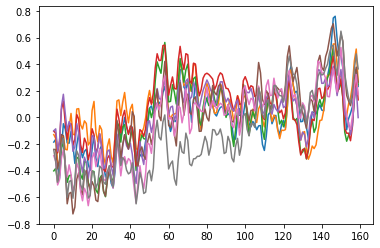

In [45]:
#visualizing data

num_data = 1
random_latent_vectors = tf.random.normal(shape=(num_data, latent_dim_b))
generated_data = b_model.generator(random_latent_vectors)
generated_data.numpy()
for i in range(num_data):
    dat = generated_data[i]
    print(dat.shape)
    plt.plot(dat[:,:,0])

Actual Data Generation

In [46]:
#Data Generation in to a file

num_generation = 6339 #1268*2 #6340*2
random_latent_vectors = tf.random.normal(shape=(num_generation, latent_dim_b))
generated_data = b_model.generator(random_latent_vectors)
generated_data.numpy()
np.save('C:/Users/telab/Downloads/datafiles/Norm_Unfil_X2_high_v2.npy', generated_data)

In [15]:
test_data = np.load('C:/Users/telab/Downloads/datafiles/Norm_Fil_X1.npy')
print(test_data.shape)

(6340, 160, 8, 1)
